# 1.改地图和障碍物前代码

-----------------------------------
R					X	

					X	

		X	X	X	X	

		X			X	

						

X	X	X	X	X		

-----------------------------------
0
20


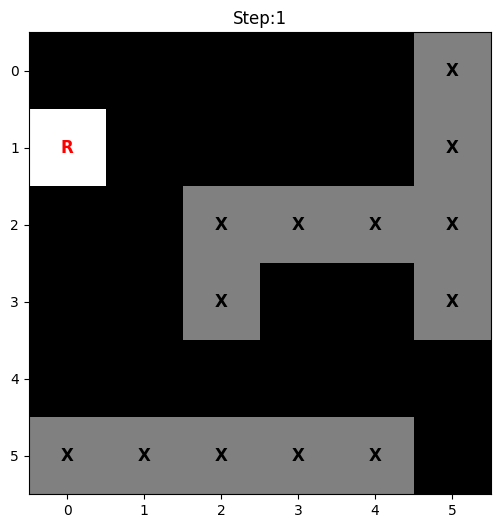

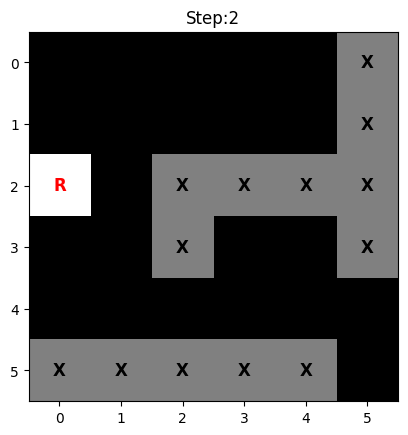

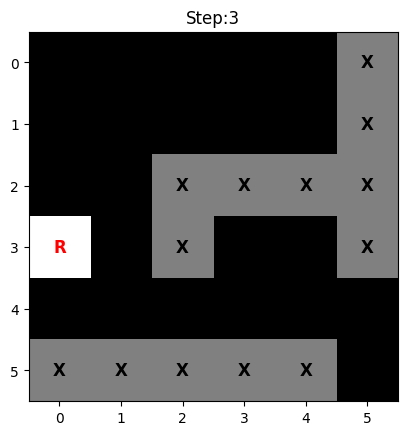

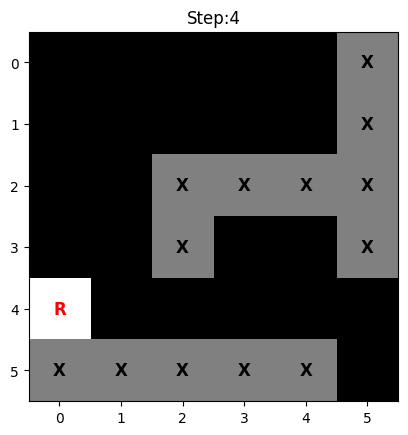

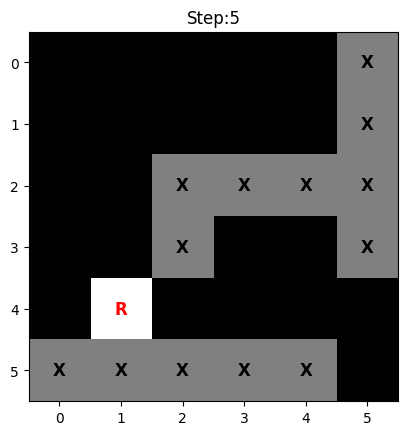

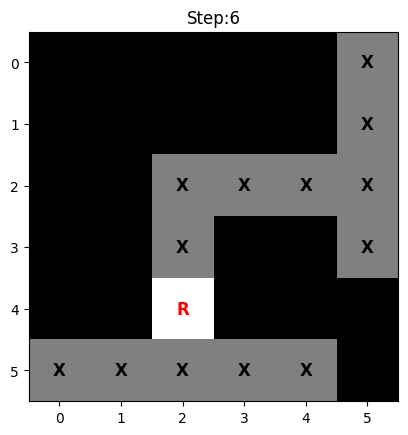

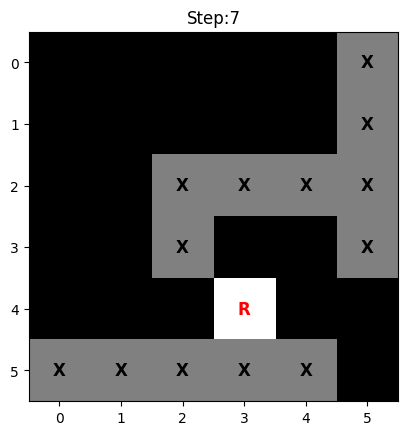

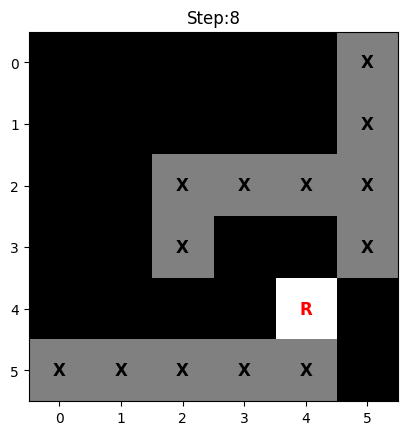

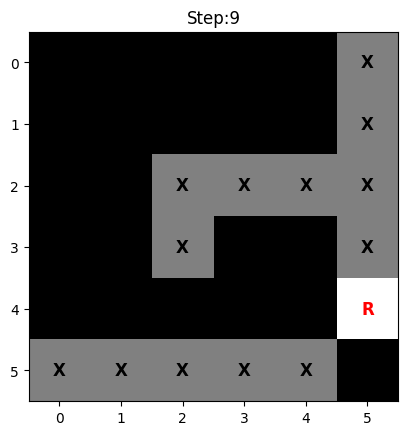

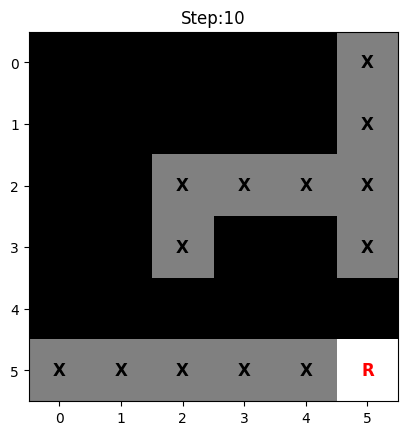

40
60
80
100


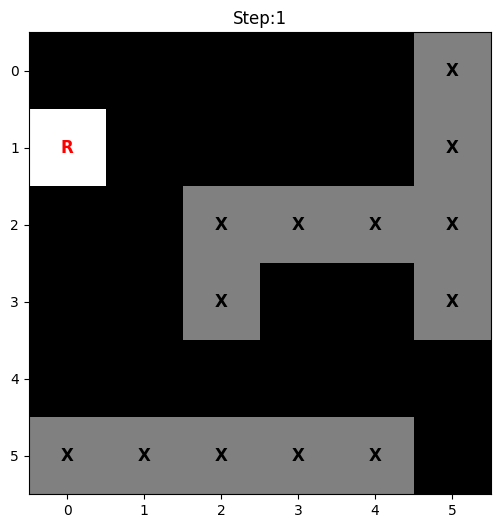

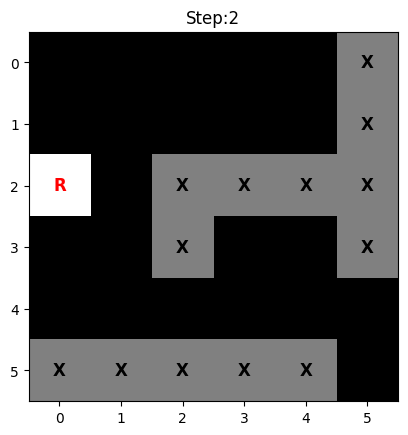

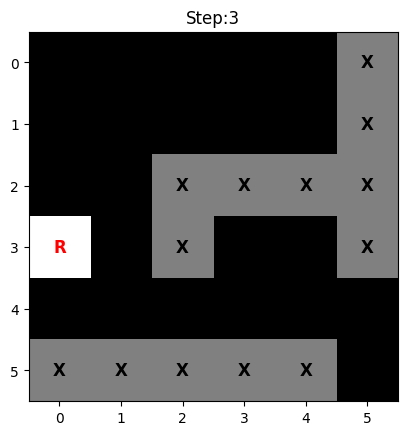

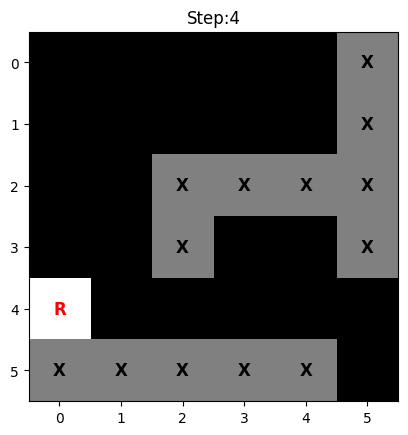

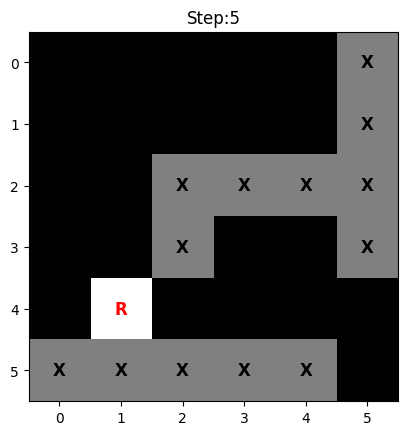

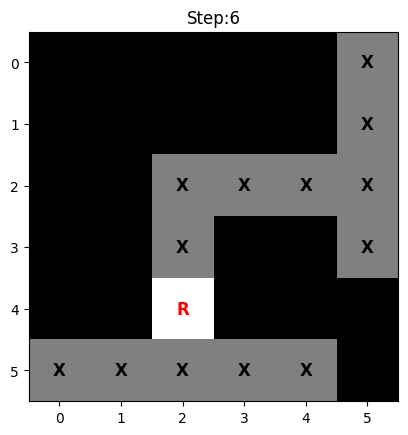

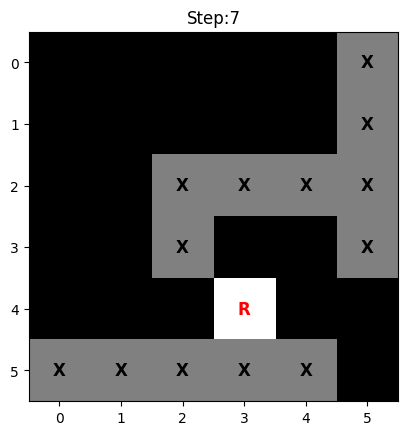

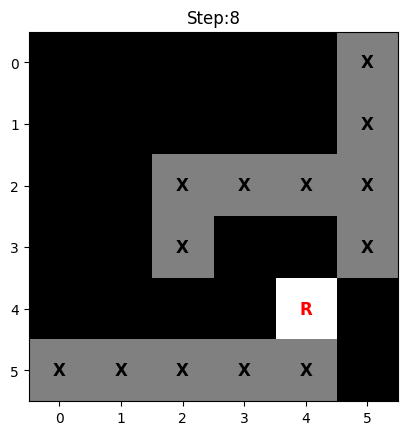

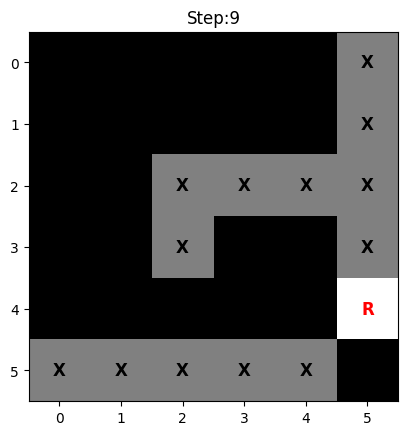

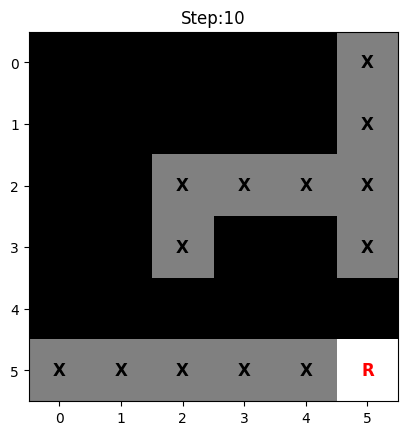

120
140
160
180
200


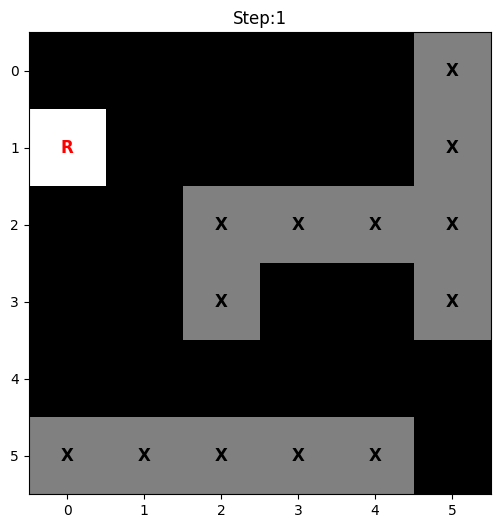

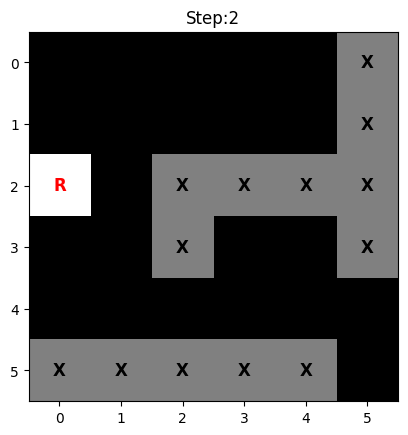

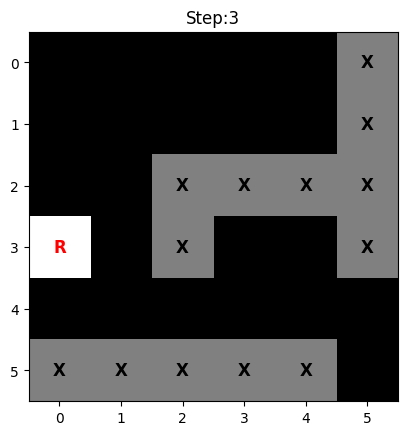

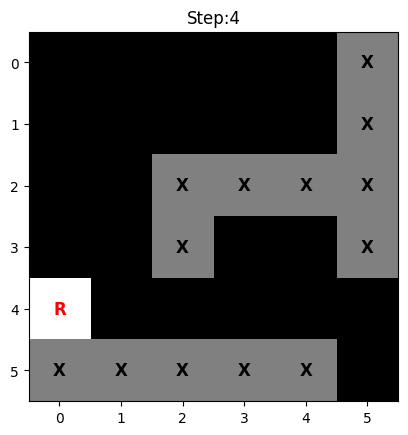

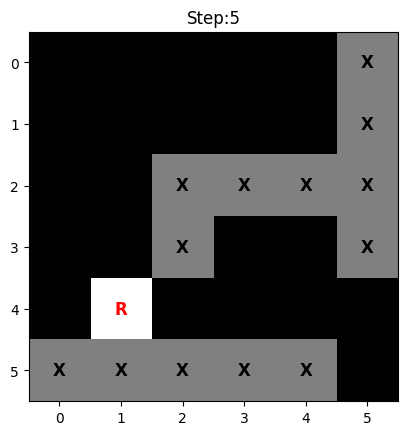

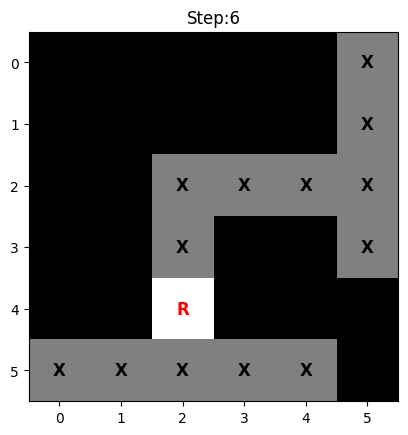

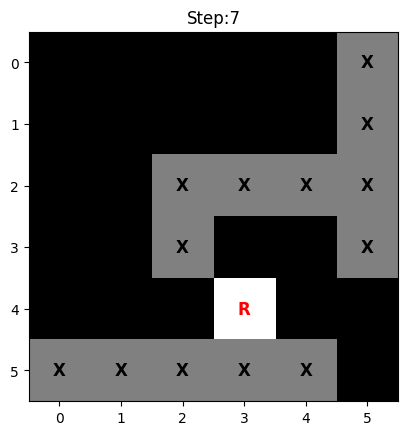

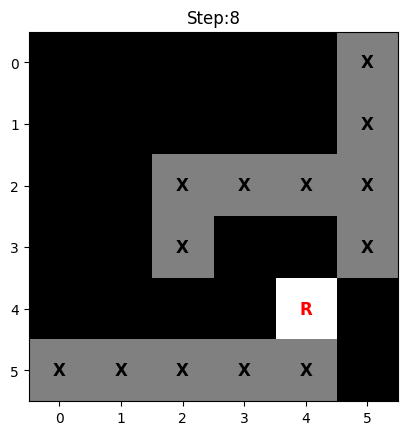

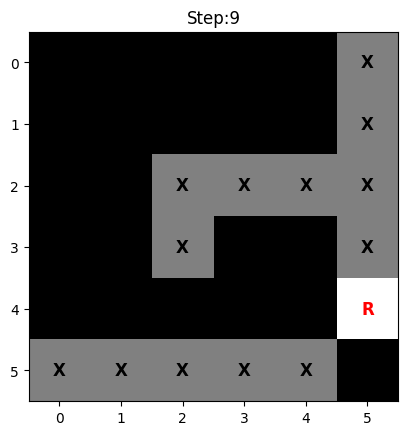

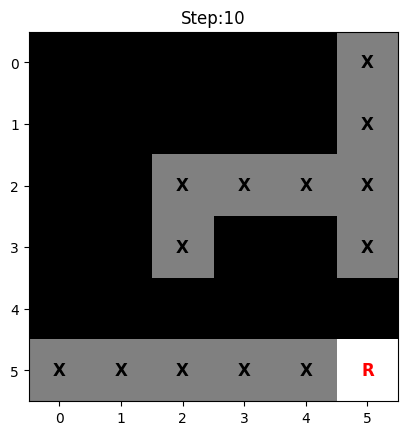

220
240
260
280
300


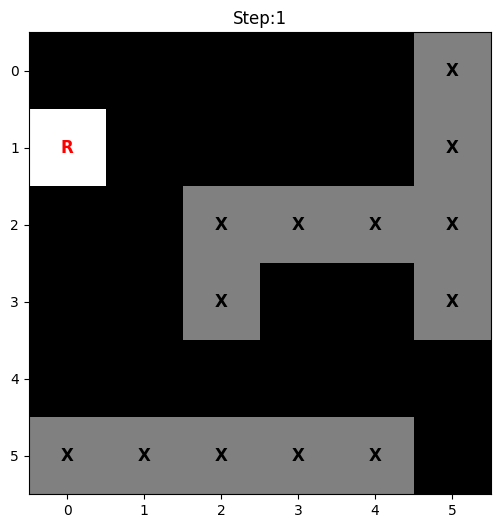

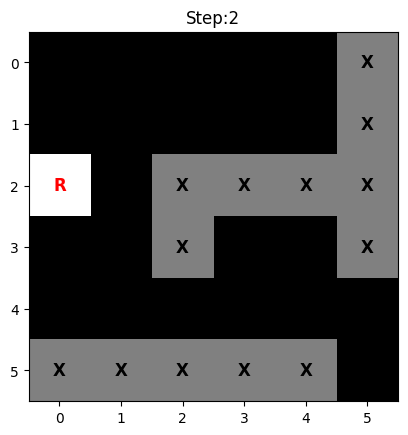

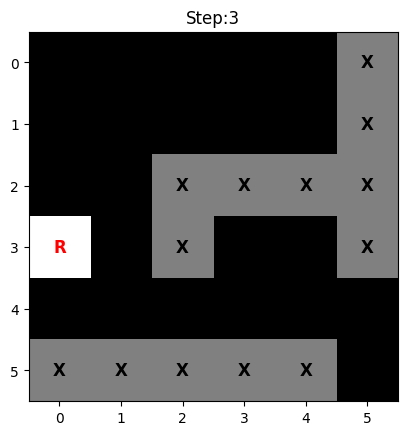

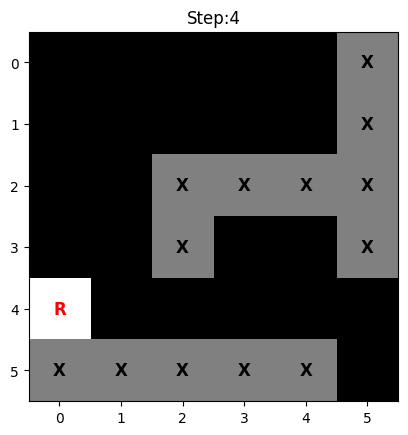

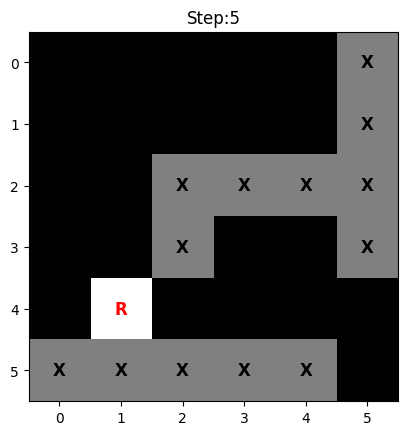

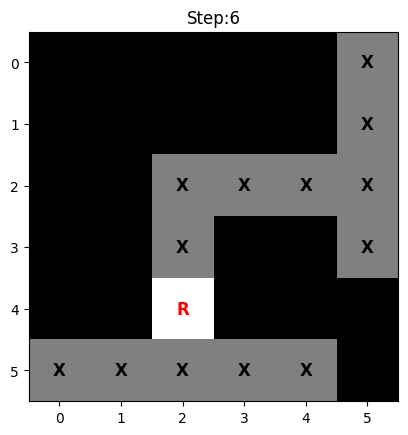

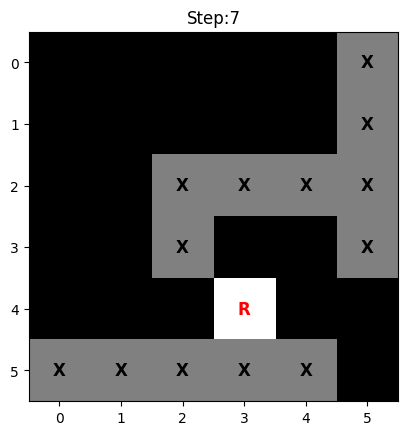

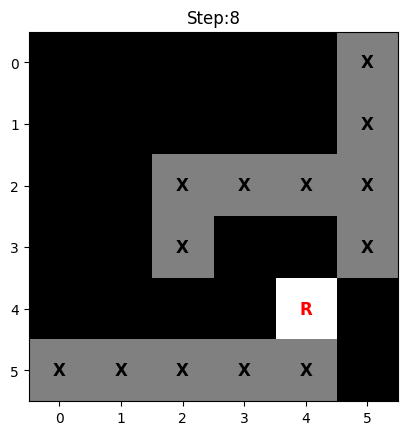

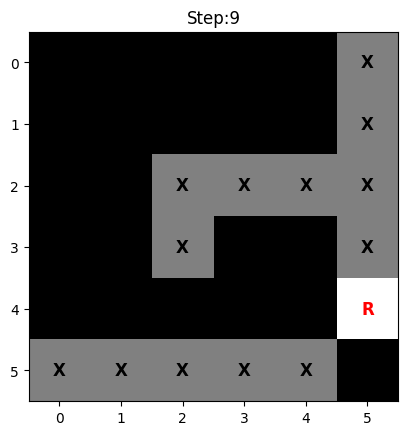

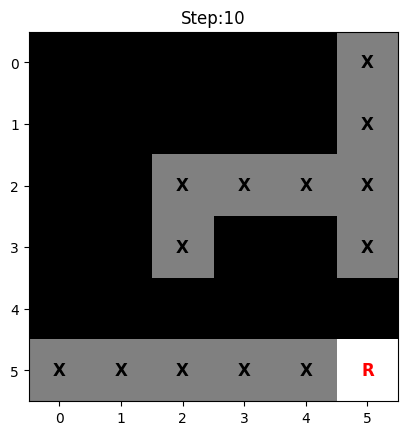

320
340
360
380
400


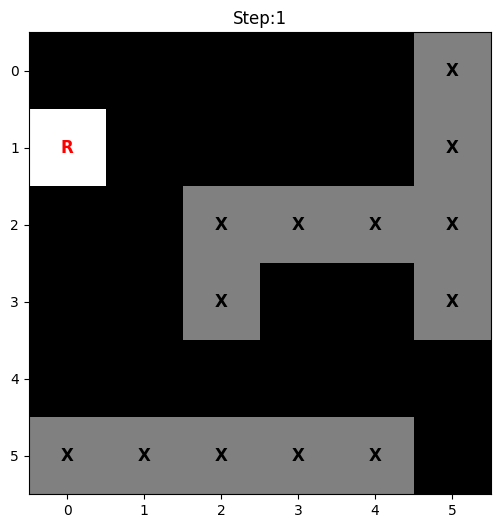

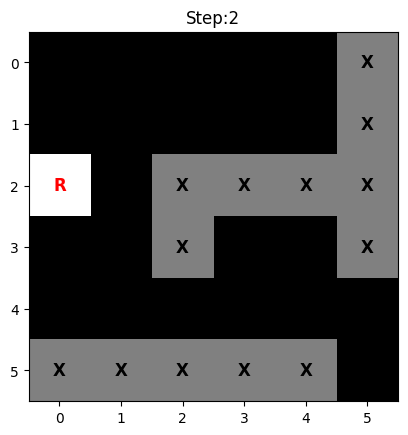

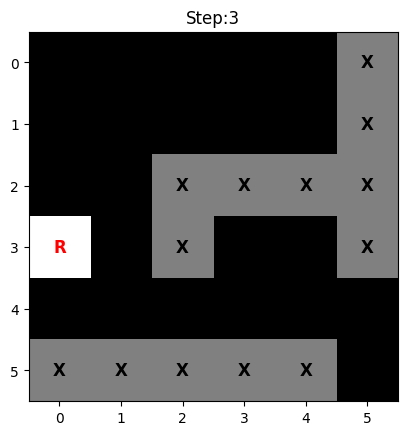

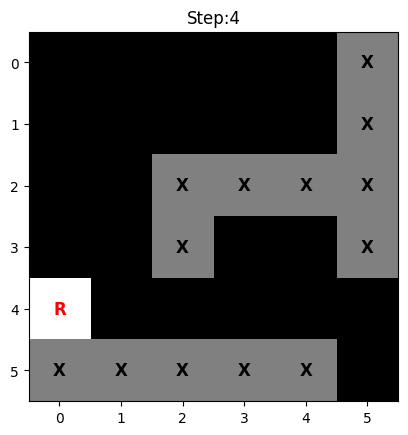

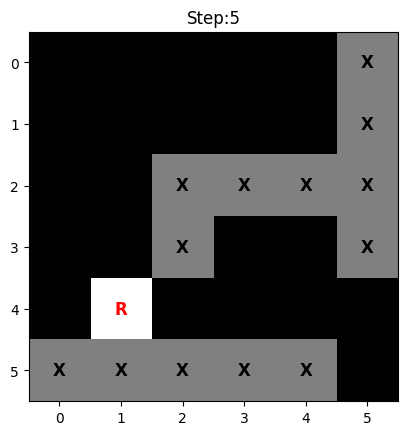

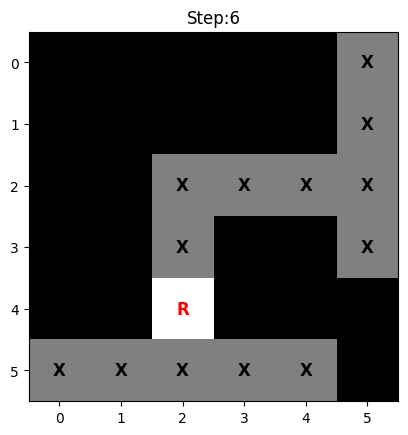

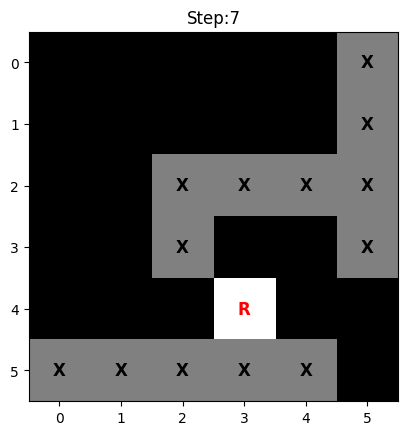

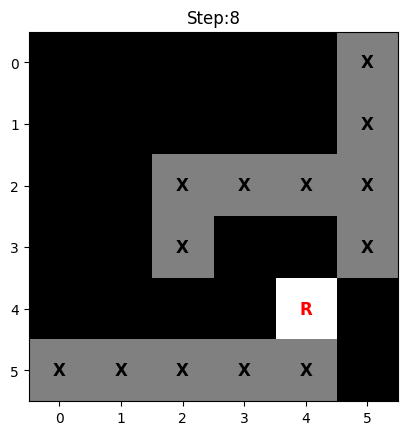

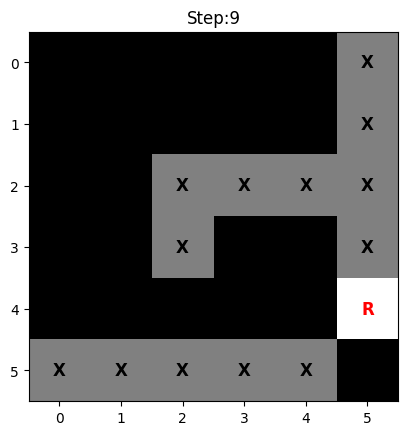

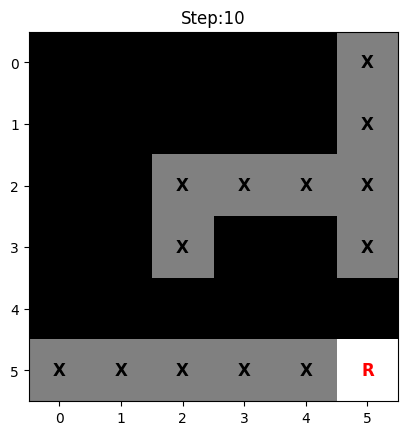

420
440
460
480
500


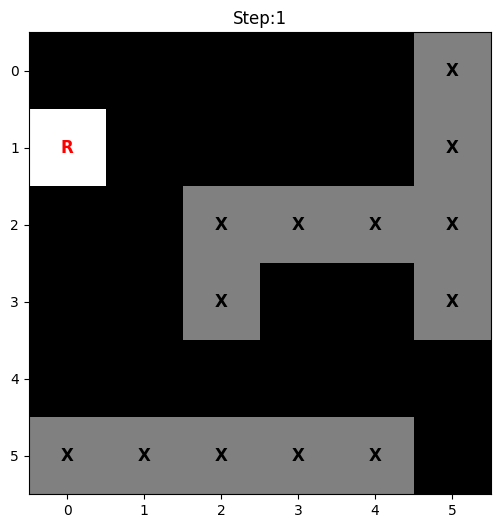

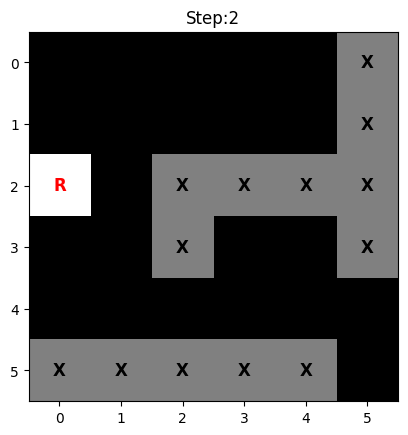

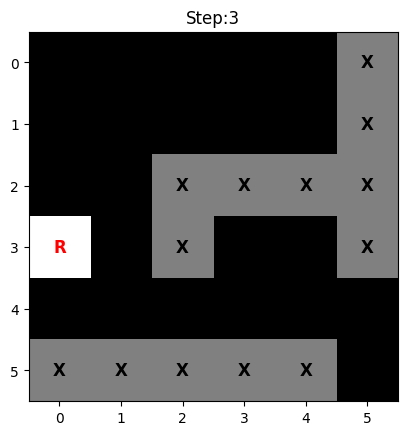

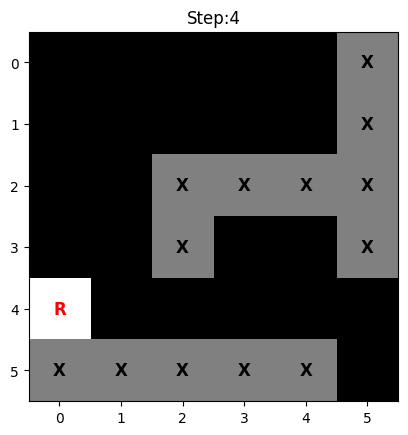

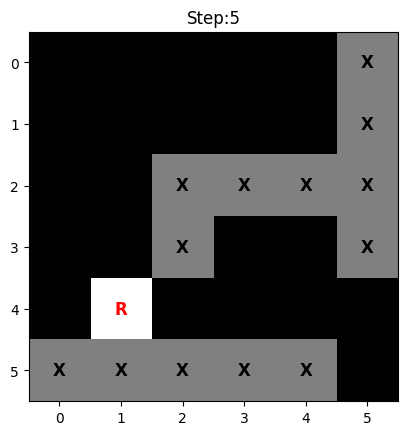

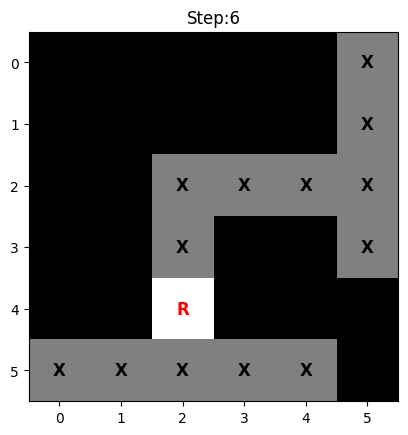

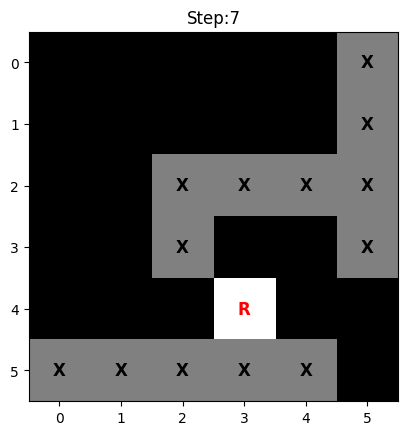

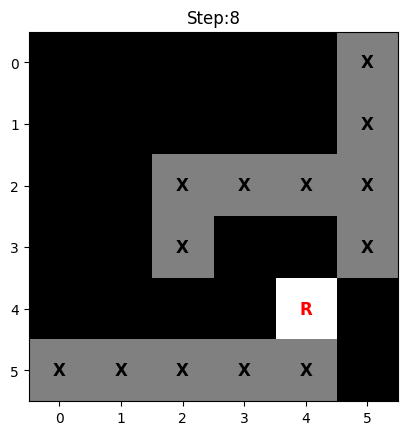

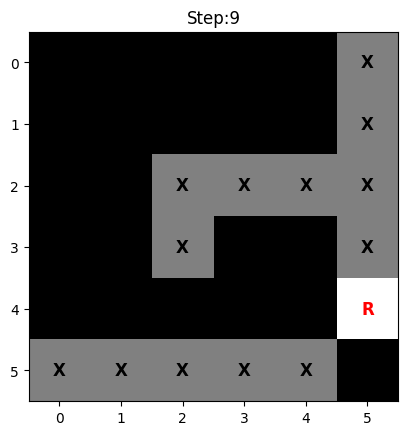

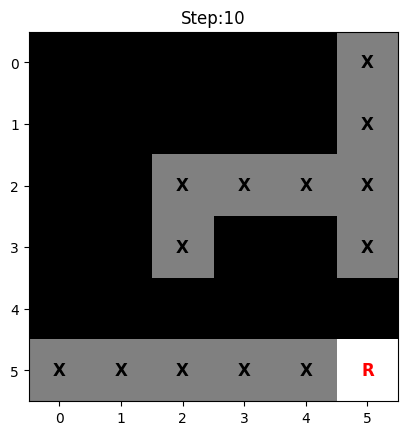

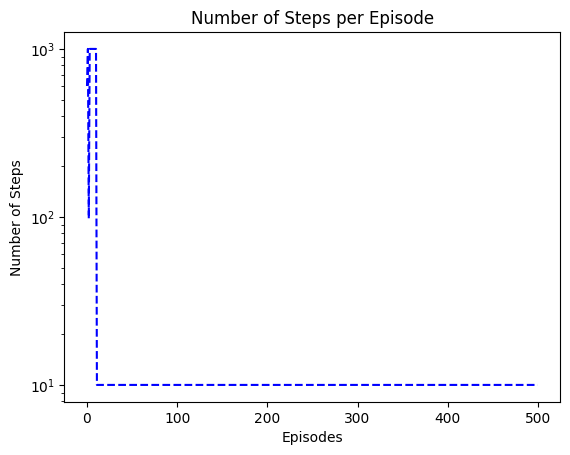

In [1]:
import numpy as np
import matplotlib.pyplot as plt



ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

class Maze(object):
    def __init__(self):
        self.maze = np.zeros((6, 6))
        self.maze[0, 0] = 2
        self.maze[5, :5] = 1
        self.maze[:4, 5] = 1
        self.maze[2, 2:] = 1
        self.maze[3, 2] = 1
        self.robot_position = (0, 0)
        self.steps = 0
        self.intermediate_states = []
        self.construct_allowed_states()

    def print_maze(self):
        print('-----------------------------------')
        for row in self.maze:
            for col in row:
                if col == 0:
                    print('', end="\t")
                elif col == 1:
                    print('X', end="\t")
                elif col == 2:
                    print('R', end="\t")
            print("\n")
        print('-----------------------------------')

    def is_allowed_move(self, state, action):
        y, x = state
        y +=ACTIONS[action][0]
        x += ACTIONS[action][1]
        if y < 0 or x < 0 or y > 5 or x > 5:
            return False

        if self.maze[y, x] == 0 or self.maze[y, x] == 2:
            return True
        else:
            return False

    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                if self.maze[(y, x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y,x),action) & (action != 0):
                            allowed_states[(y,x)].append(action)
        self.allowed_states = allowed_states

    def update_maze(self,action):
        y,x = self.robot_position
        self.maze[y,x] = 0
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.robot_position = (y,x)
        self.maze[y,x] = 2
        self.steps += 1

    def is_game_over(self):
        if self.robot_position == (5, 5):
            return True
        else:
            return False

    def get_state_and_reward(self):
        return  self.robot_position,self.give_reward()

    def give_reward(self):
        if self.robot_position == (5,5):
            return 0
        else:
            return -1

    def plot_maze(self):
        plt.figure(figsize=(6,6))
        plt.imshow(self.maze,cmap='gray',origin='upper')

        for y in range(self.maze.shape[0]):
            for x in range(self.maze.shape[1]):
                if self.maze[y,x] == 2:
                    plt.text(x, y, 'R',color='red',ha='center', va='center',fontsize=12,fontweight='bold')
                elif self.maze[y,x] == 1:
                    plt.text(x, y, 'X',color='black',ha='center', va='center',fontsize=12,fontweight='bold')
        plt.title(f'Steps:{self.steps}')
        plt.show()

    def store_intermediate_state(self):
        self.intermediate_states.append(np.copy(self.maze))

    def plot_episode(self):
        plt.figure(figsize=(6, 6))
        for i,state in enumerate(self.intermediate_states):
            plt.clf()
            plt.imshow(state,cmap='gray', origin='upper')

            for y in range(state.shape[0]):
                for x in range(state.shape[1]):
                    if state[y,x] == 2:
                        plt.text(x, y, 'R',color='red',ha='center', va='center',fontsize=12,fontweight='bold')
                    elif state[y, x] == 1:
                        plt.text(x, y, 'X',color='black',ha='center', va='center',fontsize=12,fontweight='bold')

            plt.title(f'Step:{i + 1}')
            plt.pause(0.1)

        plt.show()

class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        self.state_history = [((0, 0), 0)]
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(states)

    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j, i)] = np.random.uniform(low=1.0, high=0.1)

    def choose_action(self, state, allowedMoves):
        if not allowedMoves:
            return 'U'

        maxG = -10e15
        next_move = None
        randomN = np.random.random()

        if randomN < self.random_factor:
            next_move = np.random.choice(allowedMoves)

        else:
            for action in allowedMoves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]

        return next_move

    def update_state_history(self,state,reward):
        self.state_history.append((state,reward))

    def learn(self):
        target = 0

        for prev,reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

            self.state_history= []
            self.random_factor -= 10e-5

if __name__ == '__main__':
    maze = Maze()
    robot = Agent(maze.maze, alpha=0.1, random_factor=0.25)
    maze.print_maze()

    moveHistory = []
    for i in range(501):
        if i % 20 == 0:
            print(i)

        while not maze.is_game_over():
            state, _ =maze.get_state_and_reward()
            action = robot.choose_action(state,maze.allowed_states[state])
            maze.update_maze(action)
            state,reward = maze.get_state_and_reward()
            robot.update_state_history(state,reward)
            if maze.steps > 1000:
                maze.robot_position = (5,5)

            maze.store_intermediate_state()

        robot.learn()
        moveHistory.append(maze.steps)
        if (i == 20) or ((i>= 1)&(i % 100 == 0)):
            maze.plot_episode()
        maze = Maze()

    plt.semilogy(moveHistory, "b--")
    plt.xlabel('Episodes')
    plt.ylabel('Number of Steps')
    plt.title('Number of Steps per Episode')
    plt.show()

老地图如下：
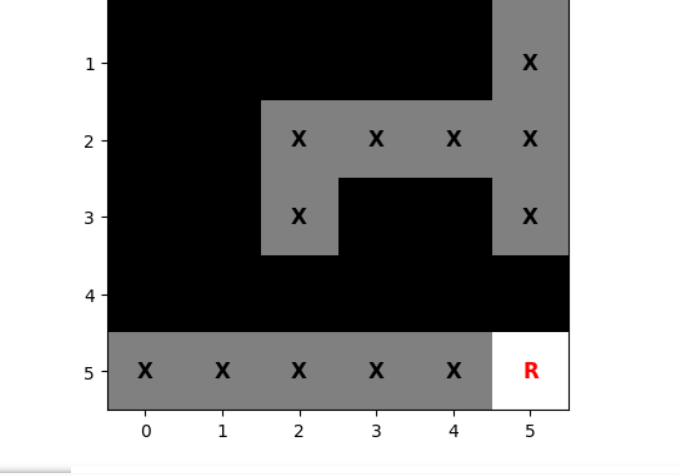

老结果如下：
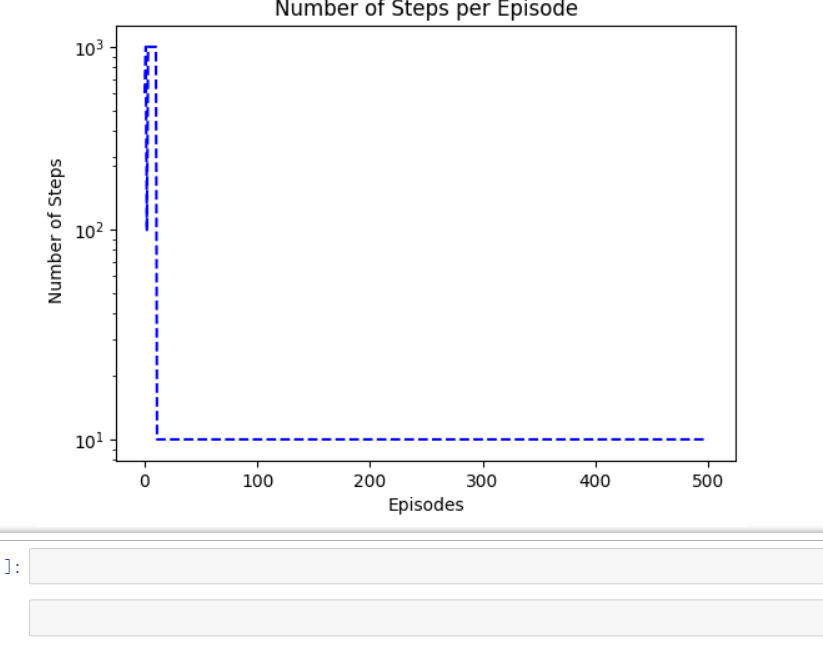

# 2.改地图和障碍物后代码

-----------------------------------
R	X					X	

		X				X	

					X	X	

X		X		X		X	

		X				X	

X	X	X	X	X		X	

-----------------------------------
0
20


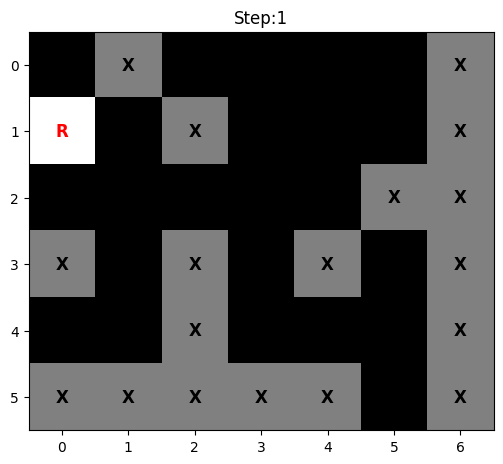

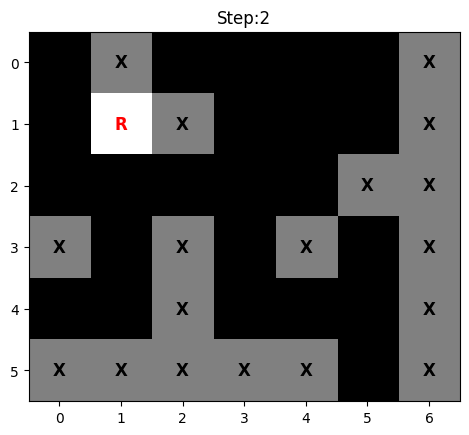

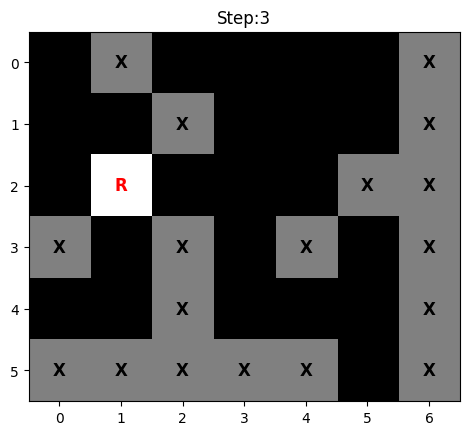

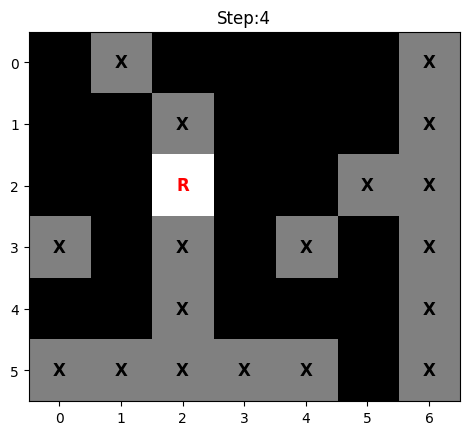

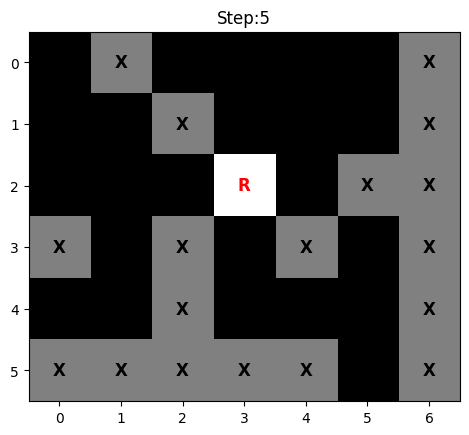

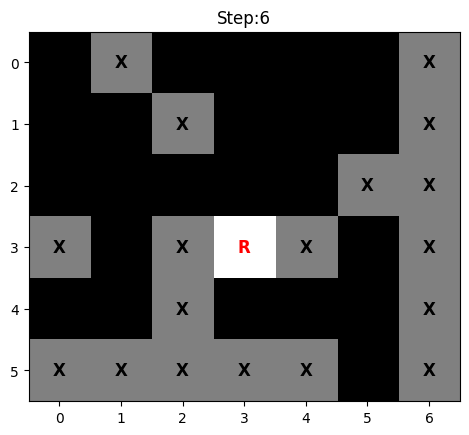

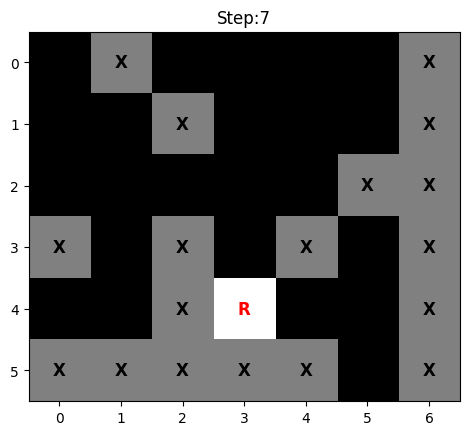

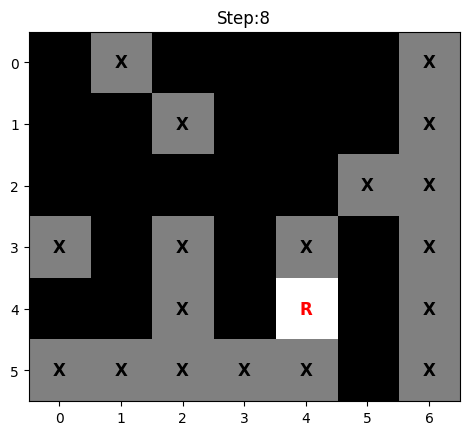

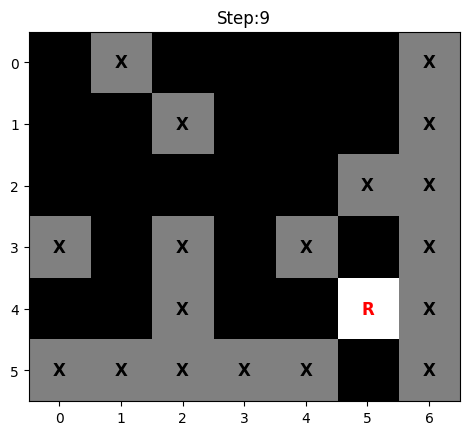

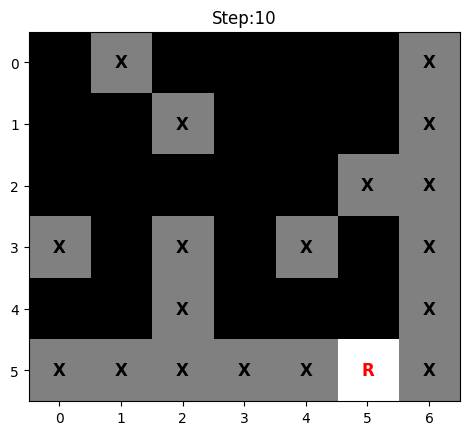

40
60
80
100


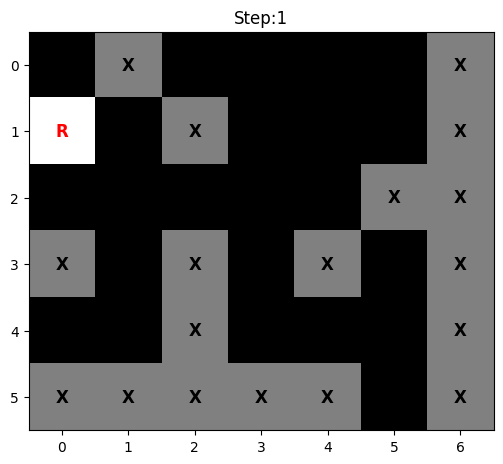

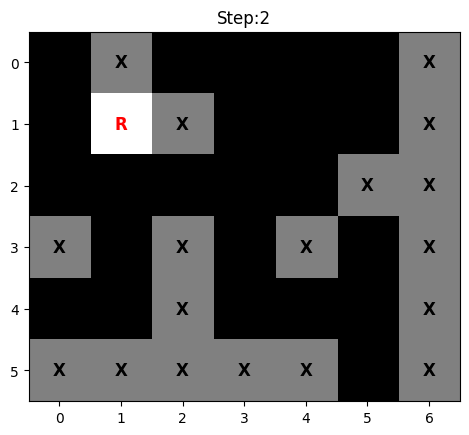

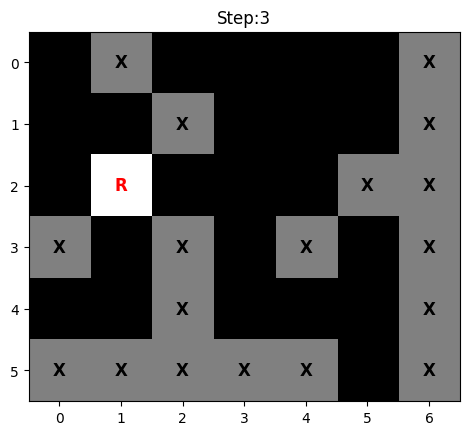

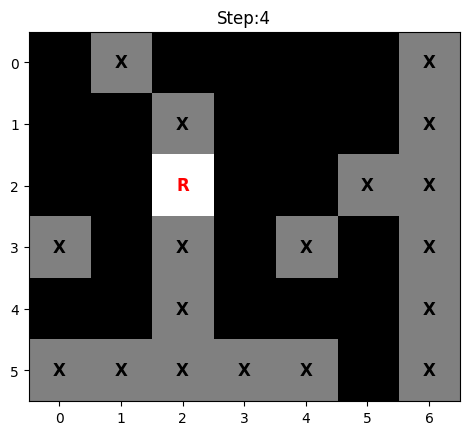

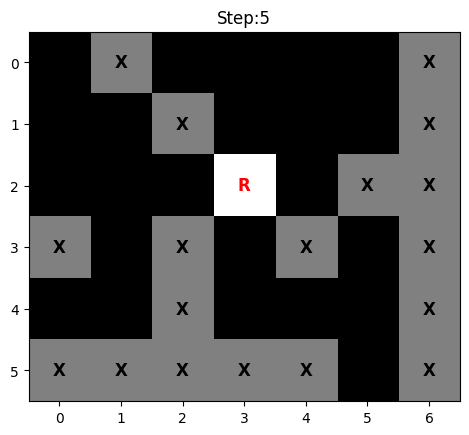

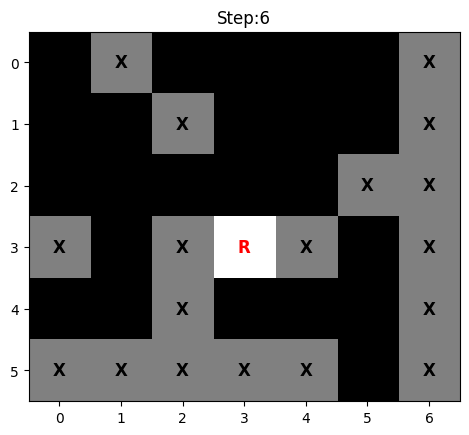

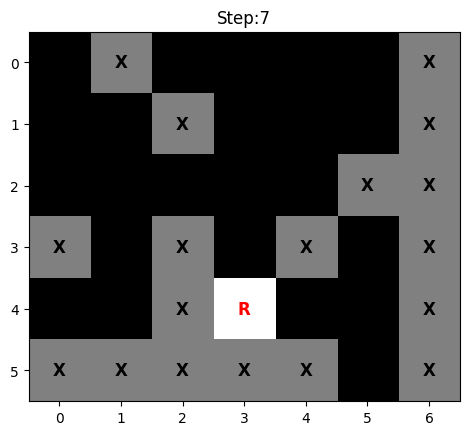

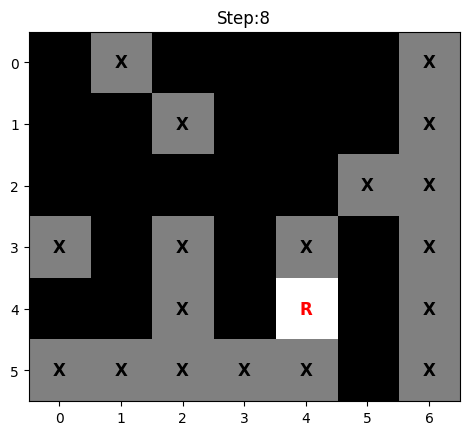

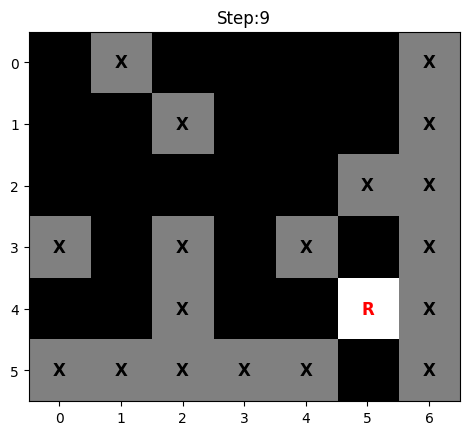

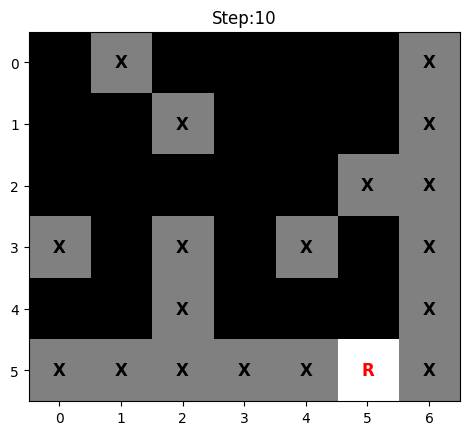

120
140
160
180
200


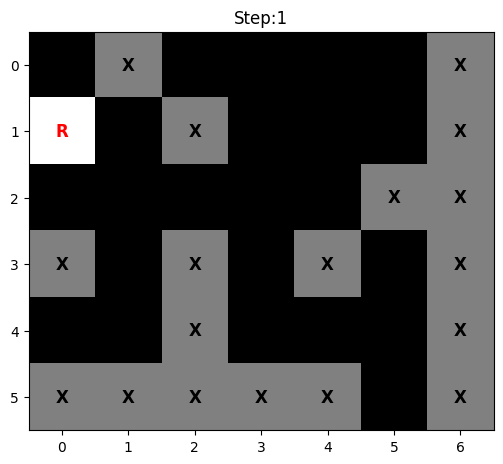

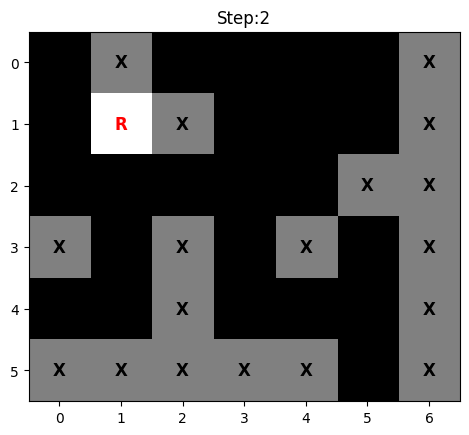

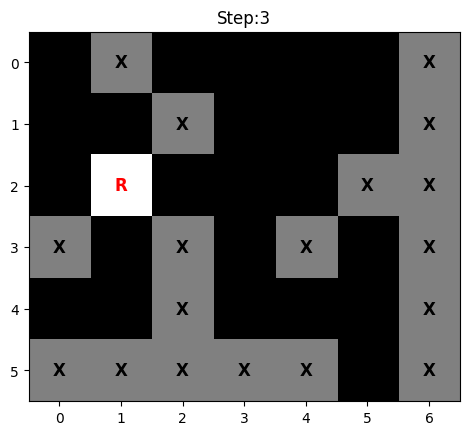

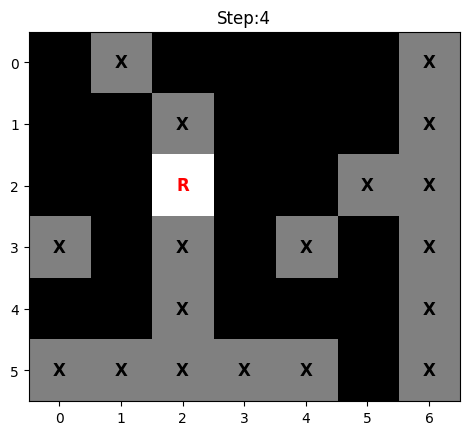

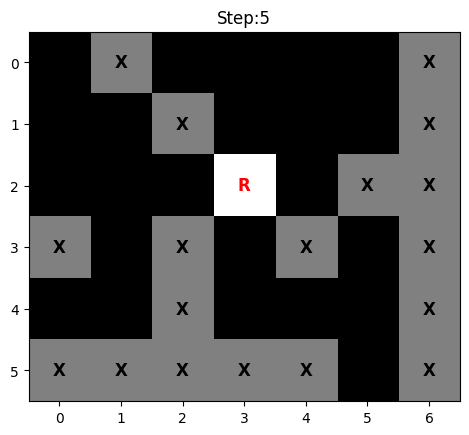

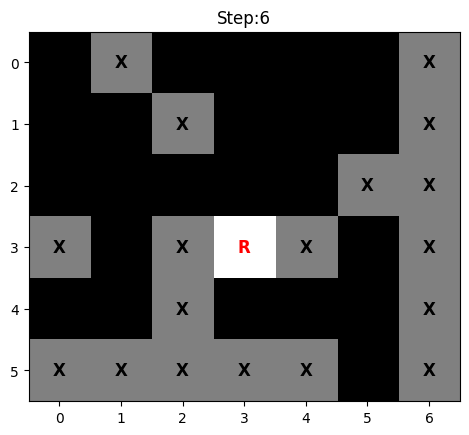

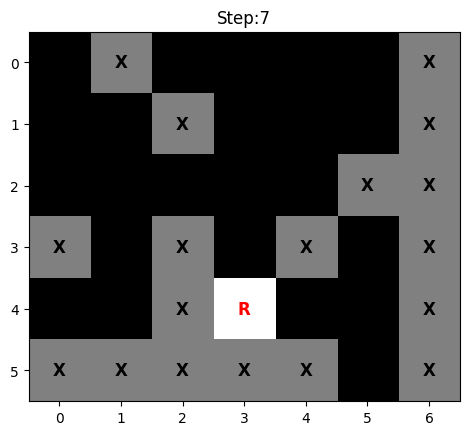

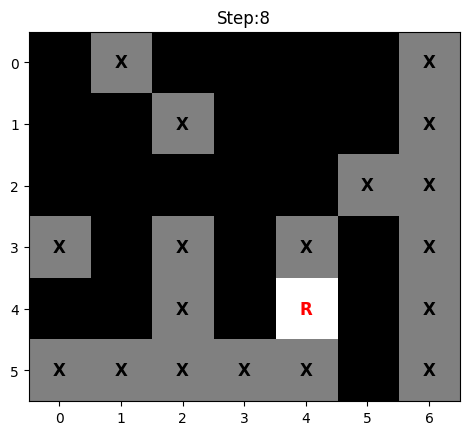

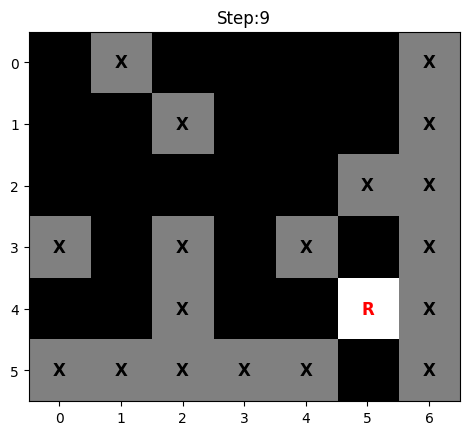

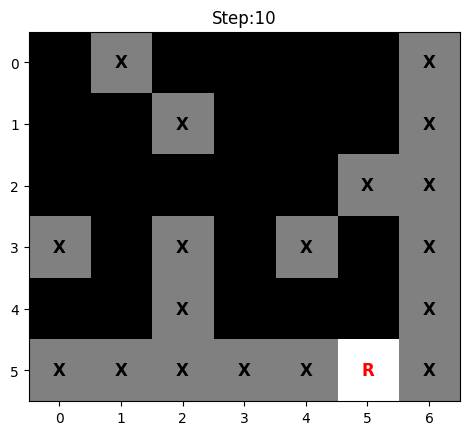

220
240
260
280
300


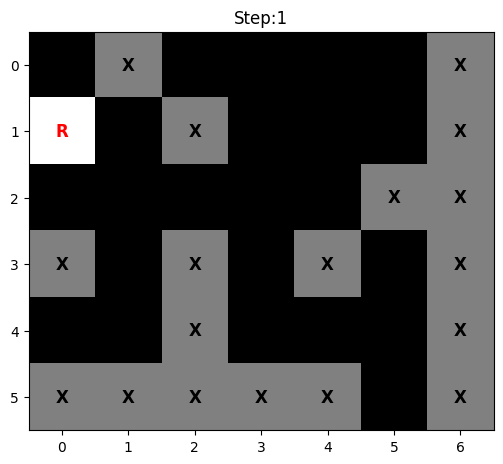

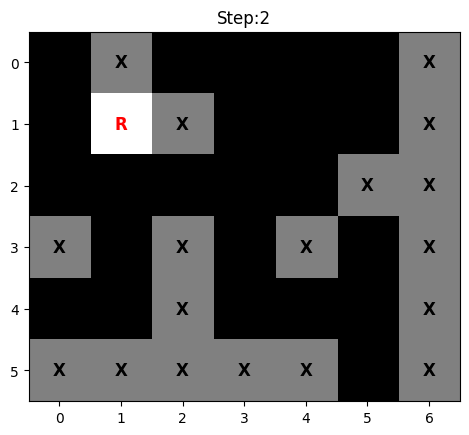

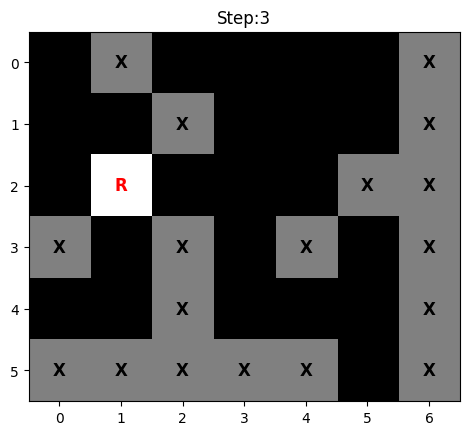

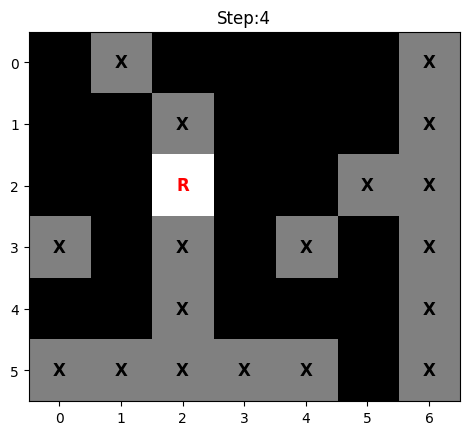

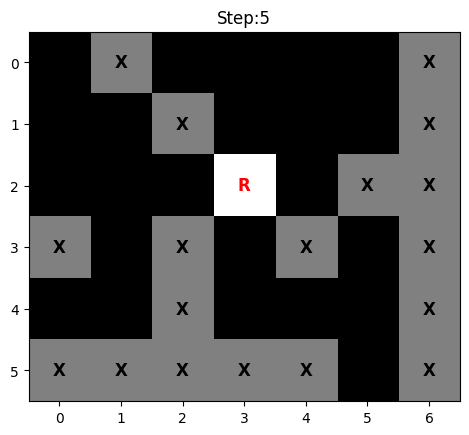

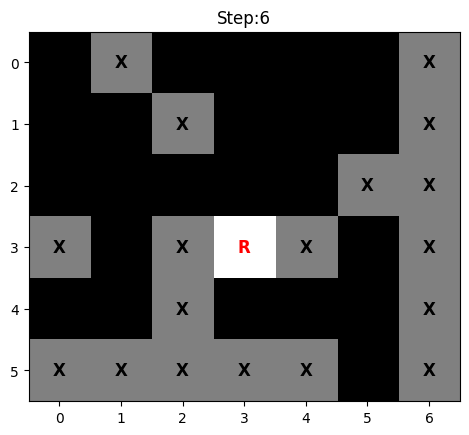

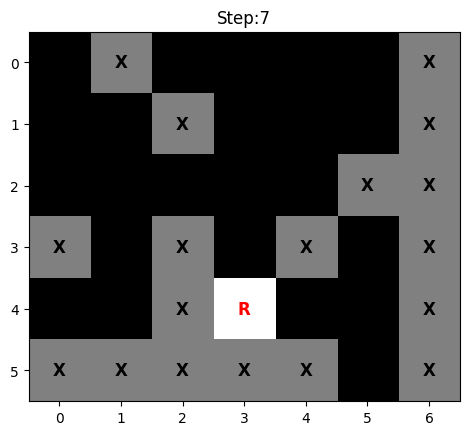

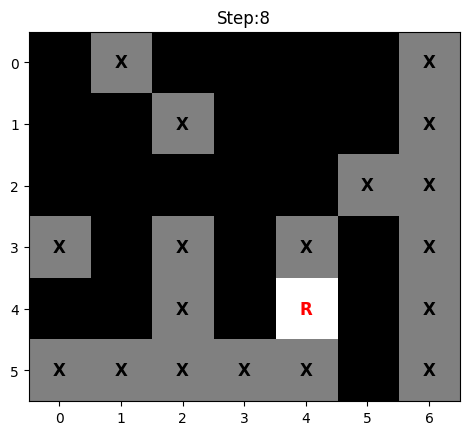

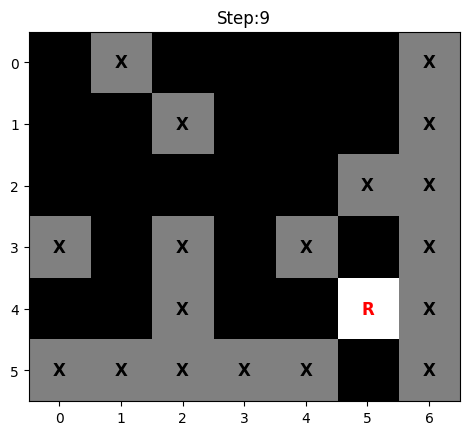

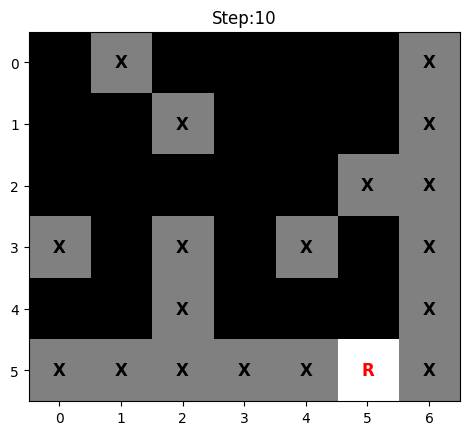

320
340
360
380
400


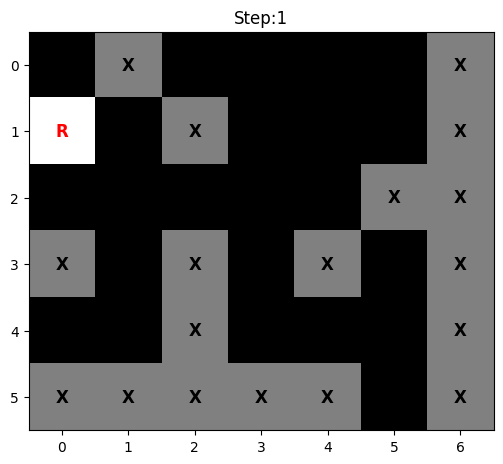

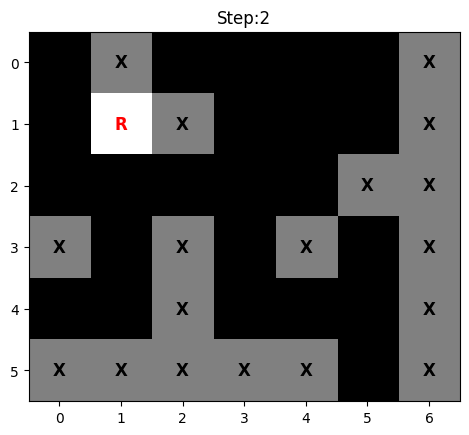

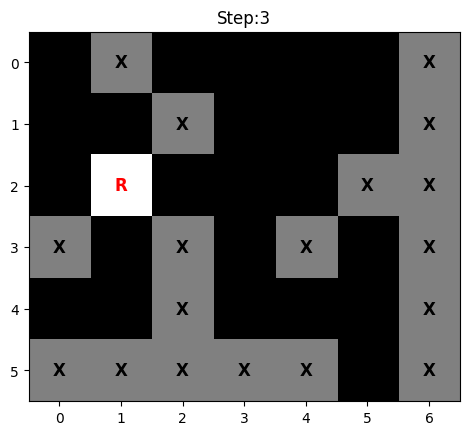

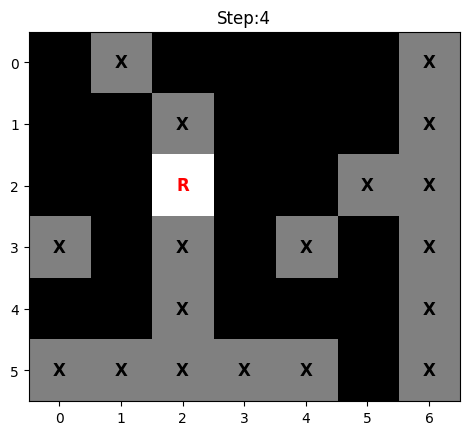

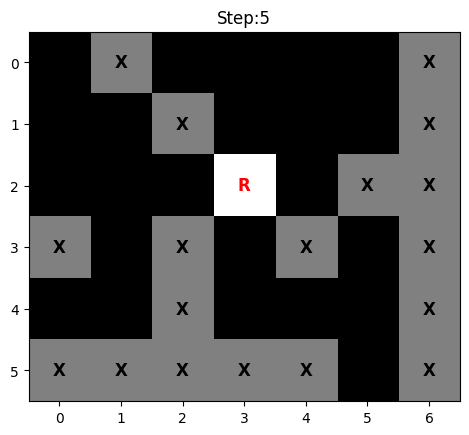

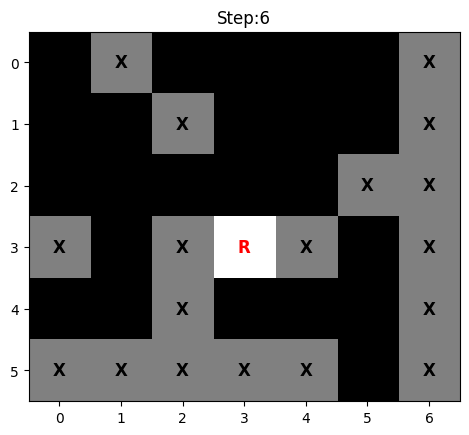

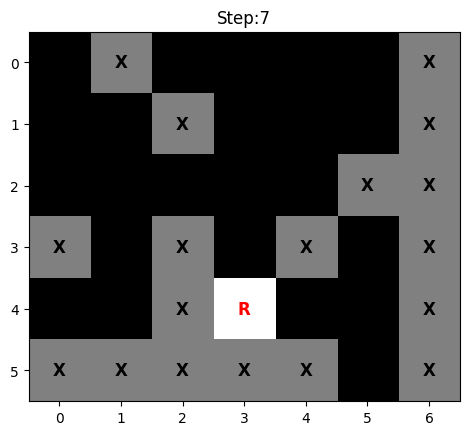

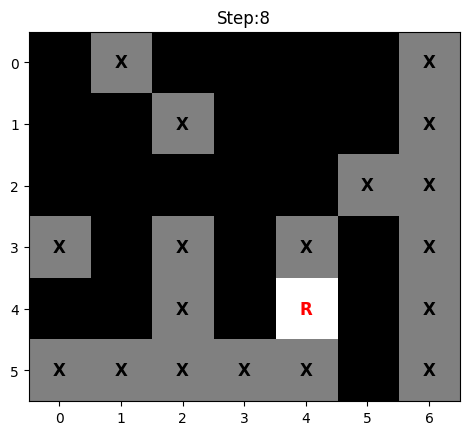

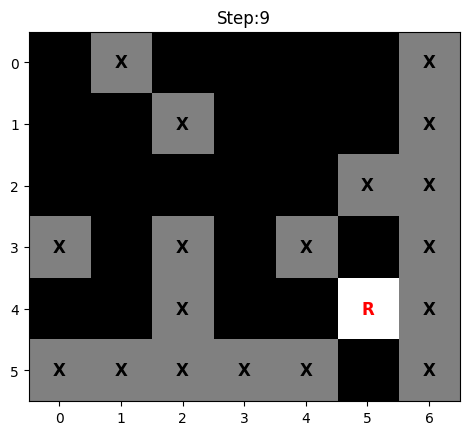

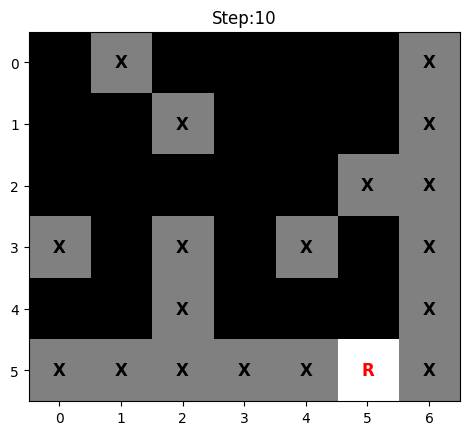

420
440
460
480
500


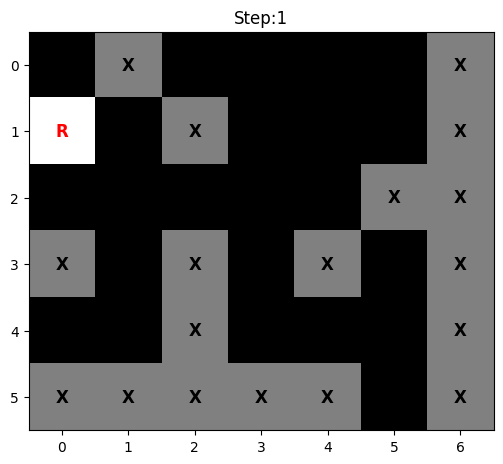

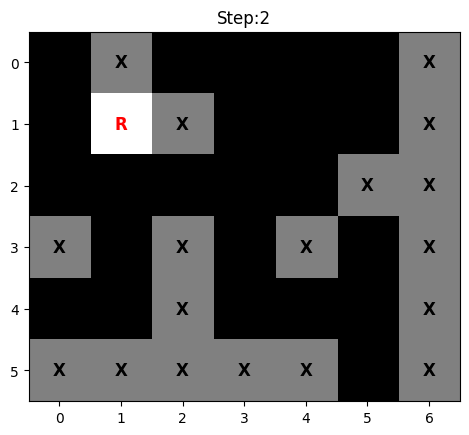

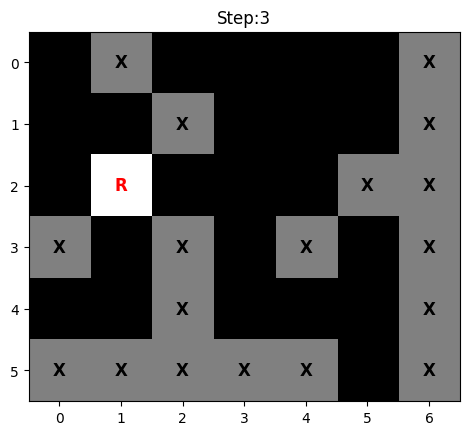

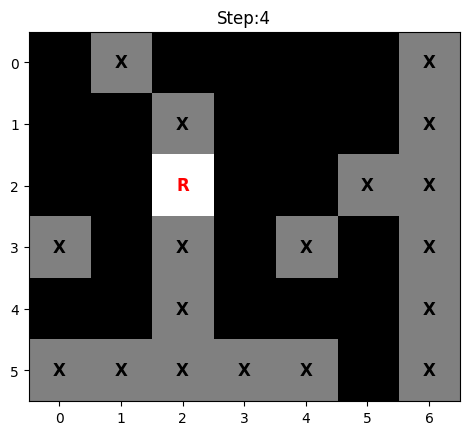

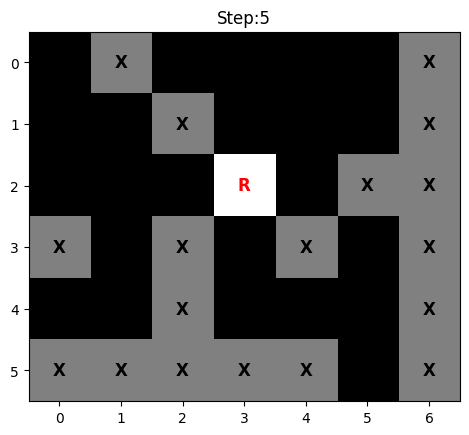

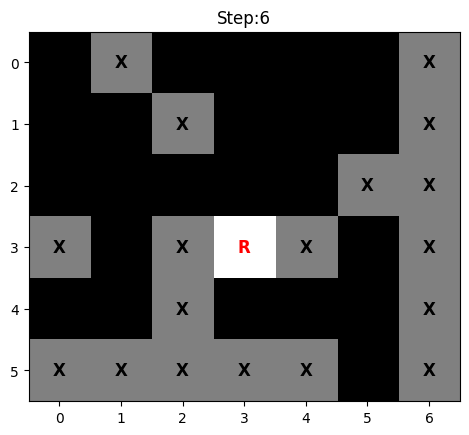

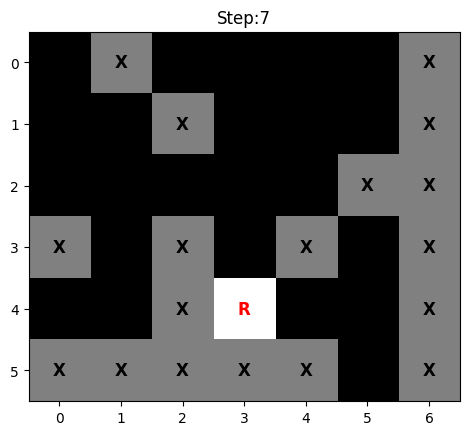

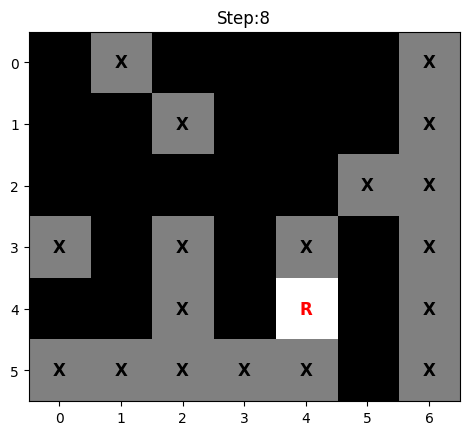

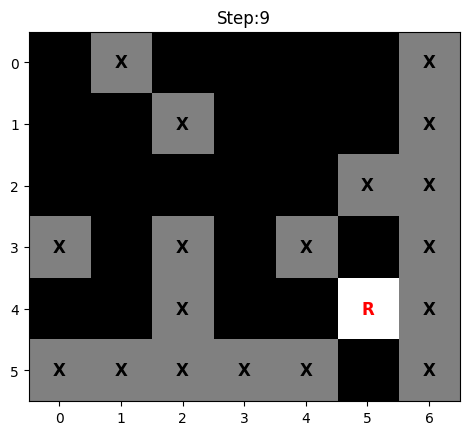

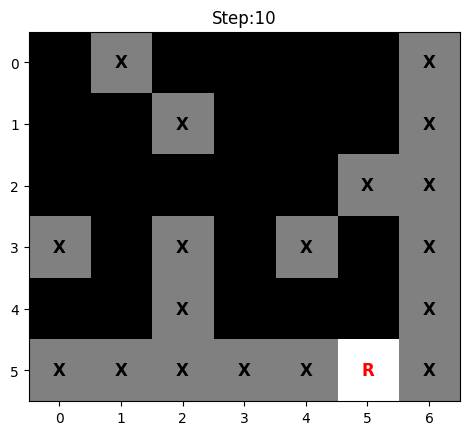

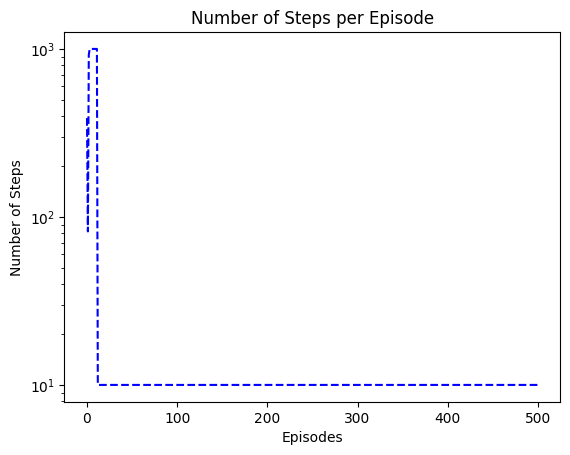

In [5]:
import numpy as np
import matplotlib.pyplot as plt

ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

class Maze(object):
    def __init__(self):
        self.maze = np.zeros((6, 7))
        self.maze[0, 0] = 2
        self.maze[0, 1] = 1
        self.maze[1, 2] = 1
        self.maze[2, 5] = 1
        self.maze[3, 0] = 1
        self.maze[3, 2] = 1
        self.maze[3, 4] = 1
        self.maze[4, 2] = 1
        self.maze[:5, 6] = 1
        self.maze[5, :5] = 1
        self.maze[5, 6] = 1
        self.robot_position = (0, 0)
        self.steps = 0
        self.intermediate_states = []
        self.construct_allowed_states()

    def print_maze(self):
        print('-----------------------------------')
        for row in self.maze:
            for col in row:
                if col == 0:
                    print('', end="\t")
                elif col == 1:
                    print('X', end="\t")
                elif col == 2:
                    print('R', end="\t")
            print("\n")
        print('-----------------------------------')

    def is_allowed_move(self, state, action):
        y, x = state
        y +=ACTIONS[action][0]
        x += ACTIONS[action][1]
        if y < 0 or x < 0 or y > 5 or x > 5:
            return False

        if self.maze[y, x] == 0 or self.maze[y, x] == 2:
            return True
        else:
            return False

    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                if self.maze[(y, x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y,x),action) & (action != 0):
                            allowed_states[(y,x)].append(action)
        self.allowed_states = allowed_states

    def update_maze(self,action):
        y,x = self.robot_position
        self.maze[y,x] = 0
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.robot_position = (y,x)
        self.maze[y,x] = 2
        self.steps += 1

    def is_game_over(self):
        if self.robot_position == (5, 5):
            return True
        else:
            return False

    def get_state_and_reward(self):
        return  self.robot_position,self.give_reward()

    def give_reward(self):
        if self.robot_position == (5,5):
            return 0
        else:
            return -1

    def plot_maze(self):
        plt.figure(figsize=(6,6))
        plt.imshow(self.maze,cmap='gray',origin='upper')

        for y in range(self.maze.shape[0]):
            for x in range(self.maze.shape[1]):
                if self.maze[y,x] == 2:
                    plt.text(x, y, 'R',color='red',ha='center', va='center',fontsize=12,fontweight='bold')
                elif self.maze[y,x] == 1:
                    plt.text(x, y, 'X',color='black',ha='center', va='center',fontsize=12,fontweight='bold')
        plt.title(f'Steps:{self.steps}')
        plt.show()

    def store_intermediate_state(self):
        self.intermediate_states.append(np.copy(self.maze))

    def plot_episode(self):
        plt.figure(figsize=(6, 6))
        for i,state in enumerate(self.intermediate_states):
            plt.clf()
            plt.imshow(state,cmap='gray', origin='upper')

            for y in range(state.shape[0]):
                for x in range(state.shape[1]):
                    if state[y,x] == 2:
                        plt.text(x, y, 'R',color='red',ha='center', va='center',fontsize=12,fontweight='bold')
                    elif state[y, x] == 1:
                        plt.text(x, y, 'X',color='black',ha='center', va='center',fontsize=12,fontweight='bold')

            plt.title(f'Step:{i + 1}')
            plt.pause(0.1)

        plt.show()

class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        self.state_history = [((0, 0), 0)]
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(states)

    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j, i)] = np.random.uniform(low=1.0, high=0.1)

    def choose_action(self, state, allowedMoves):
        if not allowedMoves:
            return 'U'

        maxG = -10e15
        next_move = None
        randomN = np.random.random()

        if randomN < self.random_factor:
            next_move = np.random.choice(allowedMoves)

        else:
            for action in allowedMoves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]

        return next_move

    def update_state_history(self,state,reward):
        self.state_history.append((state,reward))

    def learn(self):
        target = 0

        for prev,reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

            self.state_history= []
            self.random_factor -= 10e-5

if __name__ == '__main__':
    maze = Maze()
    robot = Agent(maze.maze, alpha=0.1, random_factor=0.25)
    maze.print_maze()

    moveHistory = []
    for i in range(501):
        if i % 20 == 0:
            print(i)

        while not maze.is_game_over():
            state, _ =maze.get_state_and_reward()
            action = robot.choose_action(state,maze.allowed_states[state])
            maze.update_maze(action)
            state,reward = maze.get_state_and_reward()
            robot.update_state_history(state,reward)
            if maze.steps > 1000:
                maze.robot_position = (5,5)

            maze.store_intermediate_state()

        robot.learn()
        moveHistory.append(maze.steps)
        if (i == 20) or ((i>= 1)&(i % 100 == 0)):
            maze.plot_episode()
        maze = Maze()

    plt.semilogy(moveHistory, "b--")
    plt.xlabel('Episodes')
    plt.ylabel('Number of Steps')
    plt.title('Number of Steps per Episode')
    plt.show()

新地图如下：
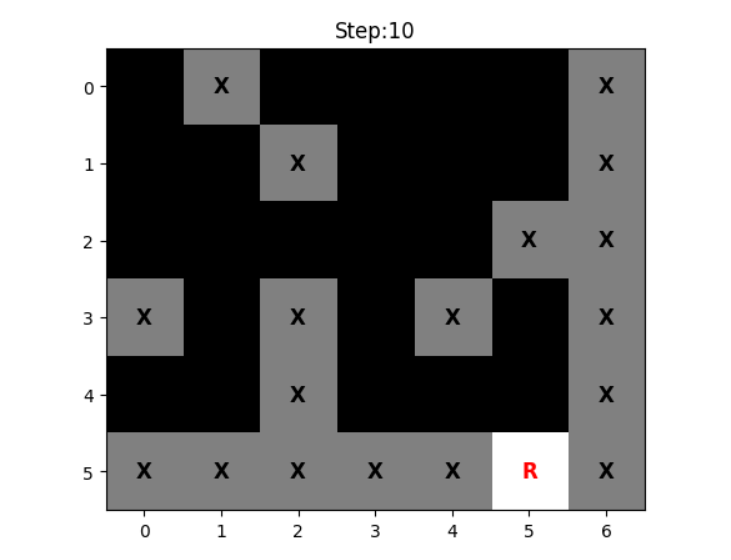

新结果如下：
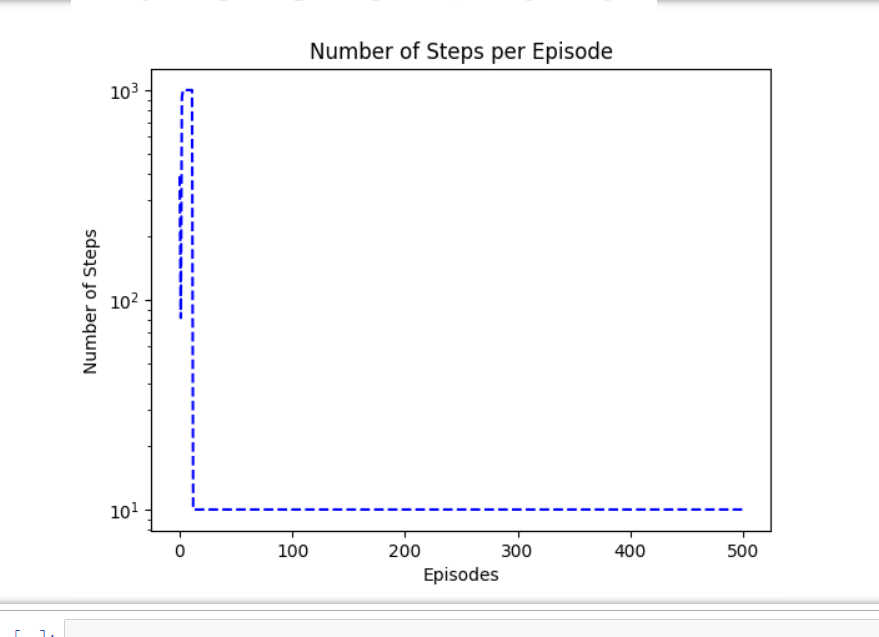

In [ ]:
前后两个版本修改部分：
 self.maze = np.zeros((6, 7))
        self.maze[0, 0] = 2
        self.maze[0, 1] = 1
        self.maze[1, 2] = 1
        self.maze[2, 5] = 1
        self.maze[3, 0] = 1
        self.maze[3, 2] = 1
        self.maze[3, 4] = 1
        self.maze[4, 2] = 1
        self.maze[:5, 6] = 1
        self.maze[5, :5] = 1
        self.maze[5, 6] = 1

对地图进行了扩大，从6乘6变成了6乘7的地图，并且对障碍物进行了新的设置。